<a href="https://colab.research.google.com/github/bluextal/lego/blob/master/lego.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a notebook doing some analysis on Lego, using data from https://brickset.com/

I'm interested to find out which sets might be good value. For me this would be partly driven by price per piece.

First we do some charting with seaborn and altair.

Then we build a regression model to understand drivers of price.

In [0]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy import nan
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import altair as alt
from IPython.display import IFrame

Data is an extract from 2017 to July 2019 stored on brickset

In [0]:
url = 'https://raw.githubusercontent.com/bluextal/lego/master/combined20171819.csv'
legodf = pd.read_csv(url)

Let's look at the most expensive lego set, over 7000 pieces, but $799 - ouch!
![alt text](https://images.brickset.com/sets/large/75192-1.jpg?201708310401)

In [223]:
legodf['USPrice'].max(axis=0, skipna = True) 

799.99

In [224]:
rowData = legodf.loc[legodf.USPrice == legodf['USPrice'].max(axis=0, skipna = True)]
print(rowData.Name)

0    Millennium Falcon
Name: Name, dtype: object


We do some charting, we can see that there is a correlation between price and number of pieces, but that it is not exact

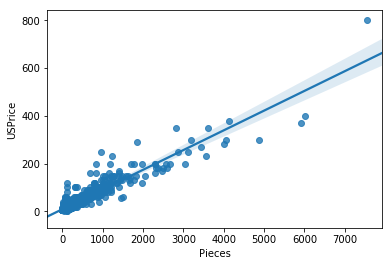

In [225]:
sns.regplot('Pieces', 'USPrice', data=legodf)

With an interactive chart we can identify sets that are particularly good value

In [226]:

alt.Chart(legodf).mark_point().encode(
    x='Pieces',
    y='USPrice',
    color='Theme',
    tooltip='Name',
).interactive()

alt.Chart(...)

In [0]:
legodf['Target']=legodf.USPrice/legodf.Pieces 
legodf = legodf[legodf.Target.notnull()]
legodf = legodf.drop(["UKPrice","EUPrice","CAPrice","ImageURL","PricePerBrick","Name"], axis=1)
legodf.fillna(0, inplace=True)

We eyeball our data

In [228]:
legodf.head()

,SetID,Number,Variant,Theme,Subtheme,Year,Minifigs,Pieces,USPrice,OwnedBy,WantedBy,Target
0,26725,75192,1,Star Wars,Ultimate Collector Series,2017,8.0,7541.0,799.99,7615,5325.0,0.106085
1,27836,71043,1,Harry Potter,General,2018,28.0,6020.0,399.99,3110,3390.0,0.066444
2,27618,10256,1,Creator Expert,Buildings,2017,0.0,5923.0,369.99,2105,1770.0,0.062467
3,24933,70620,1,The LEGO Ninjago Movie,0,2017,19.0,4867.0,299.99,5900,3608.0,0.061638
4,27828,10261,1,Creator Expert,Fairground,2018,11.0,4124.0,379.99,3495,4194.0,0.092141


And look at some summary stats

In [229]:
legodf.describe()

,SetID,Variant,Year,Minifigs,Pieces,USPrice,OwnedBy,WantedBy,Target
count,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000
mean,27679.387974,2.115321,2017.930807,2.149094,352.477759,37.854703,2125.289951,765.908567,0.256072
std,929.575868,3.473828,0.806092,2.518851,592.009966,52.123630,1945.263554,633.017501,0.524411
min,24893.000000,0.000000,2017.000000,0.000000,1.000000,2.490000,4.000000,15.000000,0.020579
25%,26853.250000,1.000000,2017.000000,0.000000,68.000000,9.990000,568.500000,346.250000,0.092512
50%,27661.500000,1.000000,2018.000000,1.000000,174.000000,19.990000,1548.500000,591.500000,0.117529
75%,28408.750000,1.000000,2019.000000,3.000000,402.750000,43.732500,3289.500000,1030.750000,0.222111
max,29562.000000,20.000000,2019.000000,28.000000,7541.000000,799.990000,13497.000000,5796.000000,9.990000


Architecture sets, which tend to have lots of pieces are cheap per piece and understandably duplo is expensive per piece.

In [230]:
legodfmean = legodf.groupby('Theme').mean().Target
print(legodfmean.sort_values())

Theme
Speed Champions                      0.085270
Architecture                         0.085711
Pirates of the Caribbean             0.087180
Ideas                                0.087433
Stranger Things                      0.087446
The LEGO Ninjago Movie               0.089045
BrickHeadz                           0.089532
Creator                              0.089725
Seasonal                             0.095023
Hidden Side                          0.096347
Creator Expert                       0.096672
Promotional                          0.098938
Elves                                0.100965
Minecraft                            0.102072
Overwatch                            0.104492
Harry Potter                         0.107293
Friends                              0.114574
Marvel Super Heroes                  0.115551
DC Super Hero Girls                  0.116165
Technic                              0.123084
Jurassic World                       0.124791
DC Comics Super Heroes      

In [231]:
legodf = pd.concat([legodf,pd.get_dummies(legodf['Theme'], prefix='Theme')],axis=1)
#legodf = pd.concat([legodf,pd.get_dummies(legodf['Subtheme'], prefix='Subtheme')],axis=1)
legodf.drop(['Theme','Subtheme','Number','USPrice'],axis=1, inplace=True)
legodf.head()

,SetID,Variant,Year,Minifigs,Pieces,OwnedBy,WantedBy,Target,Theme_Architecture,Theme_Books,Theme_Boost,Theme_BrickHeadz,Theme_City,Theme_Classic,Theme_Collectable Minifigures,Theme_Creator,Theme_Creator Expert,Theme_DC Comics Super Heroes,Theme_DC Super Hero Girls,Theme_Dimensions,Theme_Disney,Theme_Duplo,Theme_Elves,Theme_Friends,Theme_Harry Potter,Theme_Hidden Side,Theme_Ideas,Theme_Juniors,Theme_Jurassic World,Theme_Marvel Super Heroes,Theme_Minecraft,Theme_Miscellaneous,Theme_Nexo Knights,Theme_Ninjago,Theme_Overwatch,Theme_Pirates of the Caribbean,Theme_Powered Up,Theme_Promotional,Theme_Seasonal,Theme_Speed Champions,Theme_Star Wars,Theme_Stranger Things,Theme_Technic,Theme_The LEGO Batman Movie,Theme_The LEGO Ninjago Movie,Theme_The Lego Movie 2: The Second Part,Theme_The Powerpuff Girls,Theme_Toy Story,Theme_Unikitty,Theme_Xtra
0,26725,1,2017,8.0,7541.0,7615,5325.0,0.106085,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,27836,1,2018,28.0,6020.0,3110,3390.0,0.066444,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,27618,1,2017,0.0,5923.0,2105,1770.0,0.062467,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,24933,1,2017,19.0,4867.0,5900,3608.0,0.061638,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,27828,1,2018,11.0,4124.0,3495,4194.0,0.092141,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [232]:
y=legodf['Target']
X=legodf.drop(['Target','SetID'], axis=1)
X.head()

,Variant,Year,Minifigs,Pieces,OwnedBy,WantedBy,Theme_Architecture,Theme_Books,Theme_Boost,Theme_BrickHeadz,Theme_City,Theme_Classic,Theme_Collectable Minifigures,Theme_Creator,Theme_Creator Expert,Theme_DC Comics Super Heroes,Theme_DC Super Hero Girls,Theme_Dimensions,Theme_Disney,Theme_Duplo,Theme_Elves,Theme_Friends,Theme_Harry Potter,Theme_Hidden Side,Theme_Ideas,Theme_Juniors,Theme_Jurassic World,Theme_Marvel Super Heroes,Theme_Minecraft,Theme_Miscellaneous,Theme_Nexo Knights,Theme_Ninjago,Theme_Overwatch,Theme_Pirates of the Caribbean,Theme_Powered Up,Theme_Promotional,Theme_Seasonal,Theme_Speed Champions,Theme_Star Wars,Theme_Stranger Things,Theme_Technic,Theme_The LEGO Batman Movie,Theme_The LEGO Ninjago Movie,Theme_The Lego Movie 2: The Second Part,Theme_The Powerpuff Girls,Theme_Toy Story,Theme_Unikitty,Theme_Xtra
0,1,2017,8.0,7541.0,7615,5325.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,2018,28.0,6020.0,3110,3390.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2017,0.0,5923.0,2105,1770.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,2017,19.0,4867.0,5900,3608.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,2018,11.0,4124.0,3495,4194.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [234]:
regression=LinearRegression()
regression.fit(X,y)
baseregression_model=(mean_squared_error(y_true=y,y_pred=regression.predict(X)))
print(baseregression_model)

0.1460241546720633


Looking at the coefficients of the regression model we can start to understand the correlation between variables

In [235]:
coef_dict_baseline = {}
for coef, feat in zip(regression.coef_,X.columns):
    coef_dict_baseline[feat] = coef
print(coef_dict_baseline)

{'Variant': 0.00019290382474518593, 'Year': 0.012250153397630265, 'Minifigs': -0.012181308206351103, 'Pieces': -4.322446409273445e-05, 'OwnedBy': -7.201892801801317e-06, 'WantedBy': 3.0785433585391214e-05, 'Theme_Architecture': -0.38332055751637795, 'Theme_Books': 1.0549601742718817, 'Theme_Boost': -0.24424328195603176, 'Theme_BrickHeadz': -0.38004331451236434, 'Theme_City': -0.11993057233120762, 'Theme_Classic': 0.054036962286272944, 'Theme_Collectable Minifigures': 0.16973953725629728, 'Theme_Creator': -0.37281201313402956, 'Theme_Creator Expert': -0.2900344487054334, 'Theme_DC Comics Super Heroes': -0.31861359689897983, 'Theme_DC Super Hero Girls': -0.3139173339909798, 'Theme_Dimensions': -0.18225530028903353, 'Theme_Disney': -0.31189587757124176, 'Theme_Duplo': 0.3501629873162674, 'Theme_Elves': -0.31746272181992263, 'Theme_Friends': -0.33735603078832177, 'Theme_Harry Potter': -0.32004543339127306, 'Theme_Hidden Side': -0.40321704721698737, 'Theme_Ideas': -0.3358520384042767, 'Them